__Note if I want to run this notebook again, I should probably start with a smaller equality_weight, e.g. equality_weight = 2.__

In [2]:
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp

sys.path.append('/Users/roz18/git/pixel_partition')
import pp_modules
import pixel_partition_greedy

--------
## Optimization

__Load previous results:__

In [4]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
t = Table.read('/Users/roz18/git/desi-photoz/dr7/clustering/jackknife_partition/results/clustering_results_20181119.txt', format='ascii.commented_header')

hp_ra = np.array(t['ra'])
hp_dec = np.array(t['dec'])
density = np.array(t['density'])
counts = np.array(t['count'])
labels_original = np.array(t['label_scrambled'])

labels = np.copy(labels_original)

ngroup = len(np.unique(labels))
group_counts_original = np.zeros(ngroup)
average_count = np.sum(counts/ngroup)
for idx_grp in range(ngroup):
    members = np.where(labels_original==idx_grp)[0]
    group_counts_original[idx_grp] = np.sum(counts[members])

__Identify the neighbors of each occupied pixel:__

7031 bordering pixels


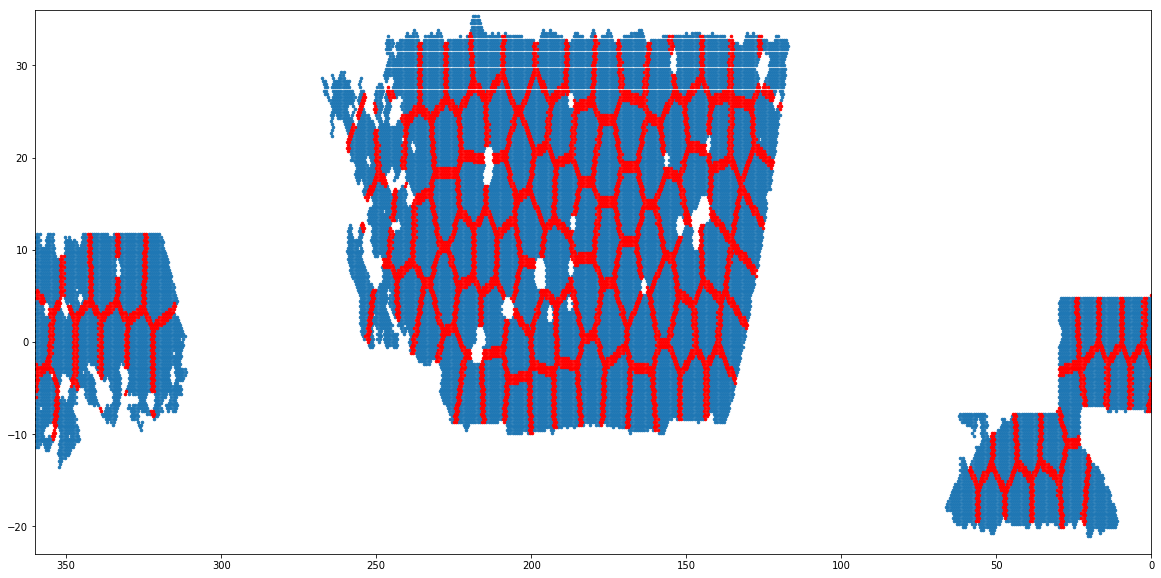

In [5]:
pix_id = hp.pixelfunc.ang2pix(NSIDE, hp_ra, hp_dec, lonlat=True)

neighbors = hp.get_all_neighbours(NSIDE, hp_ra, hp_dec, lonlat=True).T
mask = np.in1d(neighbors, pix_id).reshape(neighbors.shape)
neighbors[~mask] = -1

# Convert the neighbors array from healpix indices to generic numpy indices
pointer = -99 * np.ones(npix, dtype=int)
for index in range(len(hp_ra)):
    pointer[pix_id[index]] = index
neighbors[mask] = pointer[neighbors[mask]]

# Find bordering pixels
mask1 = labels[neighbors] != labels[:, None]
mask2 = neighbors>=0
mask_border = np.any(mask1 & mask2, axis=1)
print(np.sum(mask_border), 'bordering pixels')
plt.figure(figsize=(20, 10))
plt.plot(hp_ra[~mask_border], hp_dec[~mask_border], '.', markersize=5)
plt.plot(hp_ra[mask_border], hp_dec[mask_border], 'r.', markersize=5)
plt.axis([360, 0, -23, 36])
plt.show()

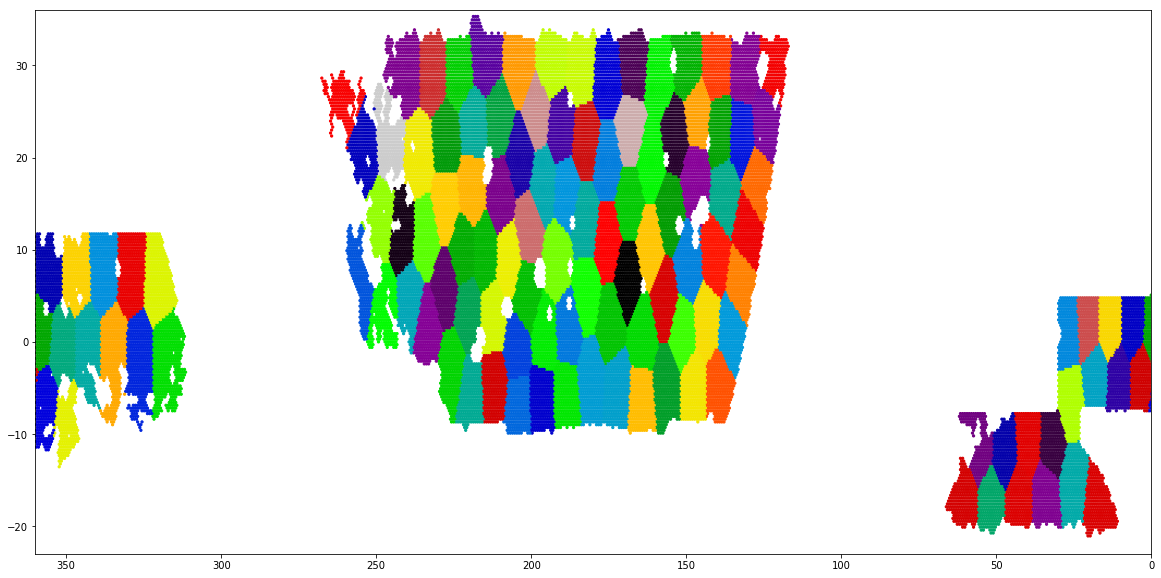

In [6]:
# Original grouping
plt.figure(figsize=(20, 10))
plt.scatter(hp_ra, hp_dec, c=labels_original, cmap='nipy_spectral', s=5)
plt.axis([360, 0, -23, 36])
plt.show()

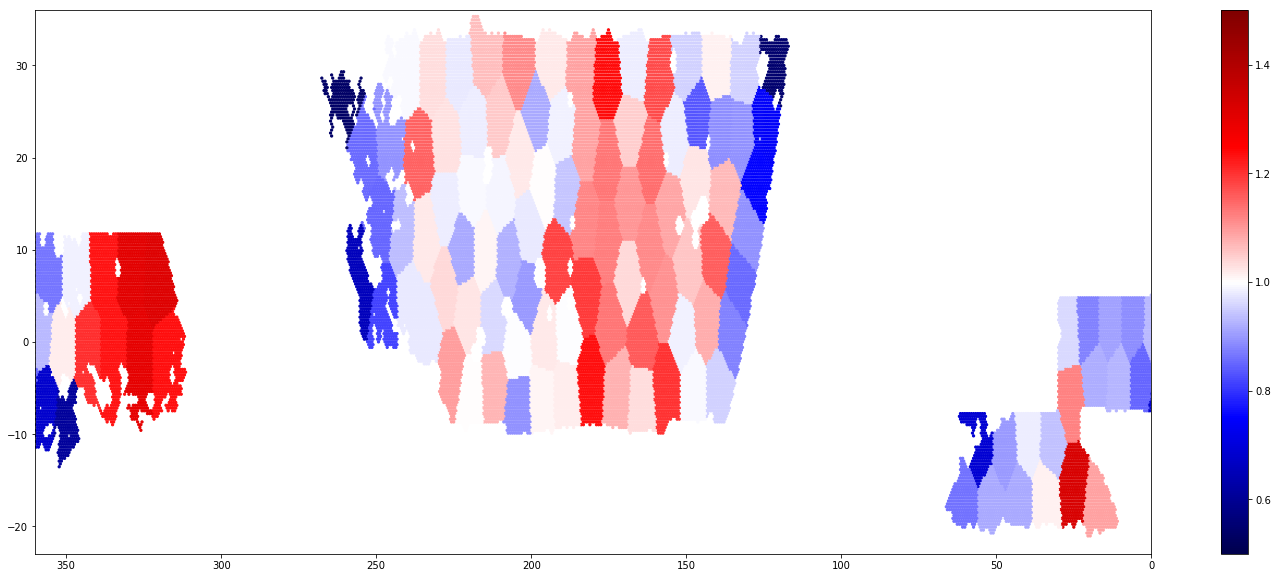

In [8]:
counts_pix_original = group_counts_original[labels_original]
plt.figure(figsize=(25, 10))
plt.scatter(hp_ra, hp_dec, c=counts_pix_original/average_count,
            cmap='seismic', s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.axis([360, 0, -23, 36])
plt.show()

In [9]:
# Parameters:
default_params = {
    'mutate_rate': 0.0015,
    'ngen': 100000,  # number of generations to run
    'equality_weight': 10., # weight of imposing equal weighted pix counts in fitness function
}

In [10]:
# Initialize
optimizer = pixel_partition_greedy.Subsampler(
    hp_ra, hp_dec, ngroup, neighbors, weights=counts, **default_params)

-----------
__Evolve!__

In [11]:
np.random.seed(2)

# fitness scores of the initial configuration
score, compactness, equality, w_counts = optimizer.fitness(labels)

score_list = []
compactness_list = []
equality_list = []

############################## Evolve! ##############################
time_start = time.time()
print('iteration          score    compactness       equality')
for idx_gen in range(default_params['ngen']):
    
    # mutate
    labels_new = optimizer.mutate(labels)
    score_temp, compactness_temp, equality_temp, w_counts_temp = optimizer.fitness(labels_new)
    
    if score_temp > score:
        labels = labels_new
        score, compactness, equality, w_counts = \
        score_temp, compactness_temp, equality_temp, w_counts_temp
    
    if idx_gen%1000==0:
        print('{:9d} {:14.5g} {:14.5g} {:14.5g}'.\
              format(idx_gen, score, compactness, equality))
        
    score_list.append(score)
    compactness_list.append(compactness)
    equality_list.append(equality)

print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

iteration          score    compactness       equality
        0        -7.8781         6.4174         1.4607
     1000        -7.7912         6.4664         1.3248
     2000        -7.7241         6.5008         1.2234
     3000        -7.6601         6.5216         1.1385
     4000         -7.601         6.5389         1.0621
     5000        -7.5477         6.5555        0.99214
     6000        -7.4934         6.5708        0.92255
     7000         -7.443         6.5788        0.86427
     8000         -7.396         6.5886         0.8074
     9000        -7.3512         6.5908        0.76042
    10000        -7.3095         6.5971         0.7124
    11000        -7.2668          6.601         0.6658
    12000         -7.223         6.6084        0.61458
    13000        -7.1883         6.6093        0.57903
    14000        -7.1532         6.6134        0.53974
    15000        -7.1234         6.6177        0.50565
    16000        -7.0949         6.6206        0.47431
    17000 

In [17]:
optimizer.equality_weight = 7.

############################## Keep evolving with modified parameters! ##############################
time_start = time.time()
print('iteration          score    compactness       equality')
for idx_gen in range(default_params['ngen']):
    
    # mutate
    labels_new = optimizer.mutate(labels)
    score_temp, compactness_temp, equality_temp, w_counts_temp = optimizer.fitness(labels_new)
    
    if score_temp > score:
        labels = labels_new
        score, compactness, equality, w_counts = \
        score_temp, compactness_temp, equality_temp, w_counts_temp
    
    if idx_gen%1000==0:
        print('{:9d} {:14.5g} {:14.5g} {:14.5g}'.\
              format(idx_gen, score, compactness, equality))
        
    score_list.append(score)
    compactness_list.append(compactness)
    equality_list.append(equality)

print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

iteration          score    compactness       equality
        0        -6.6535         6.5983       0.055259
     1000        -6.6528         6.5975       0.055289
     2000         -6.652         6.5969       0.055052
     3000        -6.6511         6.5964       0.054665
     4000        -6.6502         6.5958       0.054352
     5000        -6.6494         6.5951       0.054308
     6000        -6.6486         6.5948       0.053768
     7000         -6.648         6.5947       0.053291
     8000         -6.647         6.5946        0.05247
     9000        -6.6458          6.594       0.051799
    10000        -6.6452         6.5935        0.05167
    11000        -6.6447         6.5933       0.051397
    12000        -6.6441         6.5931       0.051069
    13000        -6.6433         6.5926       0.050668
    14000        -6.6426         6.5926        0.05005
    15000         -6.642         6.5925       0.049497
    16000        -6.6414         6.5922       0.049185
    17000 

In [20]:
default_params['ngen']
optimizer.equality_weight = 4.

############################## Keep evolving with modified parameters! ##############################
time_start = time.time()
print('iteration          score    compactness       equality')
for idx_gen in range(default_params['ngen']):
    
    # mutate
    labels_new = optimizer.mutate(labels)
    score_temp, compactness_temp, equality_temp, w_counts_temp = optimizer.fitness(labels_new)
    
    if score_temp > score:
        labels = labels_new
        score, compactness, equality, w_counts = \
        score_temp, compactness_temp, equality_temp, w_counts_temp
    
    if idx_gen%1000==0:
        print('{:9d} {:14.5g} {:14.5g} {:14.5g}'.\
              format(idx_gen, score, compactness, equality))
        
    score_list.append(score)
    compactness_list.append(compactness)
    equality_list.append(equality)

print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

iteration          score    compactness       equality
        0        -6.6055         6.5855       0.020015
     1000        -6.6055         6.5855       0.019959
     2000        -6.6053         6.5852       0.020084
     3000        -6.6051         6.5852       0.019833
     4000        -6.6046         6.5851        0.01958
     5000        -6.6045         6.5851       0.019408
     6000        -6.6042         6.5847        0.01948
     7000        -6.6038         6.5844       0.019387
     8000        -6.6038         6.5844       0.019332
     9000        -6.6035         6.5841       0.019383
    10000        -6.6031         6.5839       0.019181
    11000        -6.6031         6.5838       0.019241
    12000        -6.6029         6.5837       0.019207
    13000        -6.6028         6.5834       0.019346
    14000        -6.6028         6.5834       0.019346
    15000        -6.6027         6.5831       0.019539
    16000        -6.6026          6.583       0.019529
    17000 

In [26]:
default_params['ngen']
optimizer.equality_weight = 1.

############################## Keep evolving with modified parameters! ##############################
time_start = time.time()
print('iteration          score    compactness       equality')
for idx_gen in range(default_params['ngen']):
    
    # mutate
    labels_new = optimizer.mutate(labels)
    score_temp, compactness_temp, equality_temp, w_counts_temp = optimizer.fitness(labels_new)
    
    if score_temp > score:
        labels = labels_new
        score, compactness, equality, w_counts = \
        score_temp, compactness_temp, equality_temp, w_counts_temp
    
    if idx_gen%1000==0:
        print('{:9d} {:14.5g} {:14.5g} {:14.5g}'.\
              format(idx_gen, score, compactness, equality))
        
    score_list.append(score)
    compactness_list.append(compactness)
    equality_list.append(equality)

print(time.strftime("%H:%M:%S", time.gmtime(time.time() - time_start)))

iteration          score    compactness       equality
        0        -6.5787         6.5745      0.0042558
     1000        -6.5773         6.5719       0.005384
     2000        -6.5761         6.5702      0.0058758
     3000        -6.5747         6.5682      0.0064355
     4000        -6.5731         6.5656      0.0075296
     5000        -6.5718         6.5642      0.0076822
     6000        -6.5706         6.5622       0.008438
     7000         -6.569         6.5603       0.008671
     8000        -6.5676         6.5581      0.0095647
     9000        -6.5664         6.5568       0.009623
    10000        -6.5647         6.5553      0.0093411
    11000        -6.5639         6.5547      0.0092441
    12000        -6.5631         6.5539      0.0092156
    13000        -6.5622         6.5528      0.0094266
    14000        -6.5614         6.5522      0.0091862
    15000        -6.5606          6.551       0.009614
    16000          -6.56         6.5503      0.0097425
    17000 

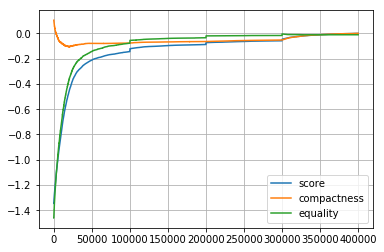

In [27]:
plt.plot(score_list-score_list[-1], label='score')
plt.plot(-np.array(compactness_list)+compactness_list[-1], label='compactness')
plt.plot(-np.array(equality_list), label='equality')
plt.legend()
plt.grid()
plt.show()

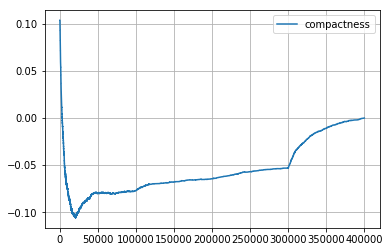

In [28]:
# plt.plot(score_list-score_list[-1], label='score')
plt.plot(-np.array(compactness_list)+compactness_list[-1], label='compactness')
# plt.plot(-np.array(equality_list), label='equality')
plt.legend()
plt.grid()
plt.show()

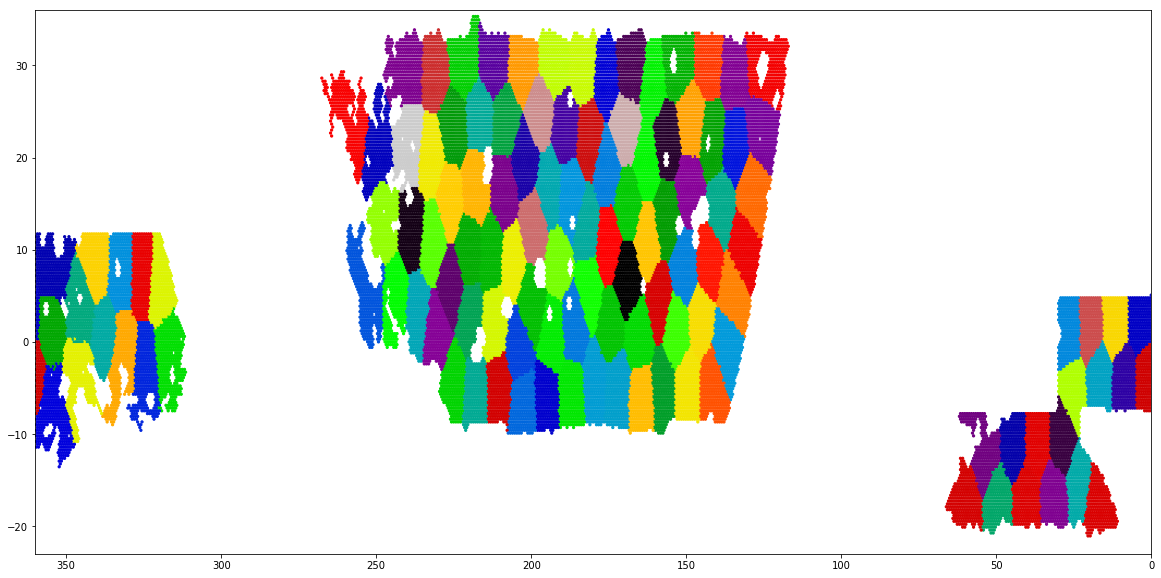

In [29]:
# Final grouping
plt.figure(figsize=(20, 10))
plt.scatter(hp_ra, hp_dec, c=labels, cmap='nipy_spectral', s=5)
plt.axis([360, 0, -23, 36])
plt.show()

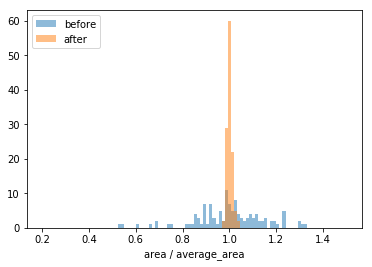

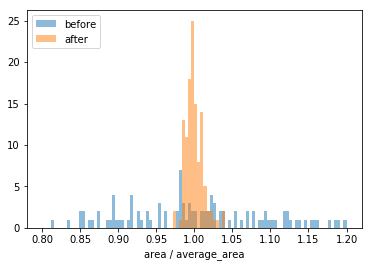

In [33]:
plt.hist(group_counts_original/optimizer.average_count, bins=100, range=(0.2, 1.5), alpha=0.5, label='before')
plt.hist(w_counts/optimizer.average_count, bins=100, range=(0.2, 1.5), alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()

plt.hist(group_counts_original/optimizer.average_count, bins=100, range=(0.8, 1.2), alpha=0.5, label='before')
plt.hist(w_counts/optimizer.average_count, bins=100, range=(0.8, 1.2), alpha=0.5, label='after')
plt.legend(loc='upper left')
plt.xlabel('area / average_area')
plt.show()

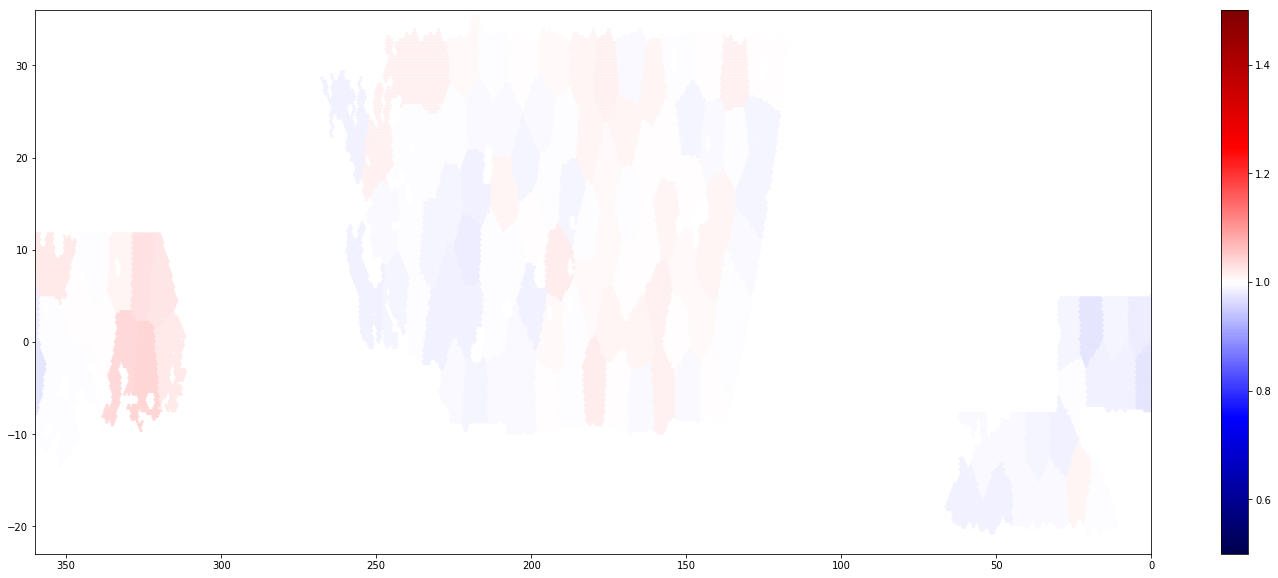

In [31]:
counts_pix = w_counts[labels]
plt.figure(figsize=(25, 10))
plt.scatter(hp_ra, hp_dec, c=counts_pix/optimizer.average_count,
            cmap='seismic', s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.axis([360, 0, -23, 36])
plt.show()

In [44]:
# Remove outlier groups and rearrange the label indices so that they are consecutive

# no outliers here
mask_outlier = np.zeros(len(hp_ra), dtype=bool)

t = Table()
t['ra'] = hp_ra[~mask_outlier]
t['dec'] = hp_dec[~mask_outlier]
t['density'] = density[~mask_outlier]
t['count'] = counts[~mask_outlier]
t['label'] = labels[~mask_outlier]

labels1 = np.unique(labels[~mask_outlier])
labels1_new = np.arange(len(labels1))
for index in range(len(labels1)):
    mask = t['label']==labels1[index]
    t['label'][mask] = labels1_new[index]

t.write('/Users/roz18/git/desi-photoz/dr7/clustering/jackknife_partition/results/jackknife_subsample_hp_greedy_20181119.txt', format='ascii.commented_header')